In [ ]:
!pip install transformers
!pip install clean-text
!pip install hazm
!pip install emoji

In [2]:
import re
import emoji
from hazm import *
import numpy as np
import pandas as pd
import tensorflow as tf
from cleantext import clean
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from transformers import  AutoTokenizer, TFBertModel, TFBertForSequenceClassification

In [3]:
labelled_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/Codes /data_labelled.csv"
labelled_data = pd.read_csv(labelled_data_path, index_col=0)
print(labelled_data.shape)
labelled_data.head( )

(3596, 4)


,text,label,comment_len,clean_text
id,,,,
131244574,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...,0,27,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...
133141894,دوستان این نظرات و پیشنهادات رو باید به پشتیبا...,0,24,دوستان نظرات پیشنهاد پشتیبان تیک اسنپ فرستاد#ف...
94129372,خیلی ایراد داره مسخره تر از این نمیشه رقیب‌هات...,1,25,ایراد مسخره نمیشه رقیبهات روح ماشین رد میشن ام...
131334220,نه کی گفته خرابه من دارم باهاش کار میکنم از من...,0,20,خرابه با کار رایگانه ممنون سازنده ستاره کمه
131387172,سلام عالیه حتما نصب کنید از کالاف دیوتی هم بهتره,0,10,سلام عالیه نصب کالاف دیوتی بهتره


Use a pretrained Bert Model From HF as Classifier

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model = TFBertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_classifier = TFBertForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", num_labels=2)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(labelled_data.clean_text.to_numpy(), labelled_data.label.to_numpy(), test_size = 0.1, random_state=42, stratify=labelled_data.label.to_numpy())
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)

print(f'train data shape for semi_supervised learning : {X_train.shape}')
print(f'train label shape for semi_supervised learning : {y_train.shape}')

print(f'validation data shape for semi_supervised learning : {X_valid.shape}')
print(f'validation label shape for semi_supervised learning : {y_valid.shape}')

print(f'validation data shape for semi_supervised learning : {X_test.shape}')
print(f'validation label shape for semi_supervised learning : {y_test.shape}')

train data shape for semi_supervised learning : (2588,)
train label shape for semi_supervised learning : (2588,)
validation data shape for semi_supervised learning : (360,)
validation label shape for semi_supervised learning : (360,)
validation data shape for semi_supervised learning : (648,)
validation label shape for semi_supervised learning : (648,)


In [6]:
train_encoding= bert_tokenizer([str(comment) for comment in X_train], max_length=100, truncation=True, padding='max_length')
dev_encoding = bert_tokenizer([str(comment) for comment in X_valid], max_length=100, truncation=True, padding='max_length')

###### bert with custom network

In [14]:
train_input_ids = np.array(train_encoding['input_ids'])
train_attention_mask = np.array(train_encoding['attention_mask'])

dev_input_ids = np.array(dev_encoding['input_ids'])
dev_attention_mask = np.array(dev_encoding['attention_mask'])


In [19]:
dev_attention_mask.shape

(360, 100)

In [20]:
input_ids = tf.keras.Input(shape=(100, ),dtype='int32')
attention_masks = tf.keras.Input(shape=(100, ),dtype='int32')
bert_output = bert_model([input_ids,attention_masks])
output = bert_output[1]
output = tf.keras.layers.Dense(1000,activation='relu')(output)
output = tf.keras.layers.Dense(1000,activation='relu')(output)
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(500,activation='relu')(output)
output = tf.keras.layers.Dense(500,activation='relu')(output)
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(100,activation='relu')(output)
output = tf.keras.layers.Dense(100,activation='relu')(output)
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
transormers_model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
transormers_model.layers[2].trainable = False
transormers_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             162841344   ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 1000)         769000      ['tf_bert_model[1][1]']    

In [21]:
from tensorflow import keras

callbacks = [
            keras.callbacks.ModelCheckpoint(
              filepath="{epoch:02d}-{val_loss:.2f}.hdf5",
              save_weights_only=True,
              monitor='val_loss',
              mode='min',
              save_best_only=True),
            keras.callbacks.EarlyStopping(patience=10,
                                          restore_best_weights=True,
                                          monitor='val_loss')
            ]
transormers_model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['accuracy'],
)
# bert_model.load_weights("/content/drive/MyDrive/Colab Notebooks/*** TO DO ***/NLP/Persian_News/07-0.25.hdf5")

In [22]:
transormers_history=transormers_model.fit([train_input_ids, train_attention_mask], y_train, validation_data=([dev_input_ids, dev_attention_mask], y_valid), epochs=50, callbacks=[callbacks])

Epoch 1/50
81/81 [==============================] - 48s 384ms/step - loss: 0.1576 - accuracy: 0.6743 - val_loss: 0.1544 - val_accuracy: 0.6750
Epoch 2/50
81/81 [==============================] - 25s 303ms/step - loss: 0.1425 - accuracy: 0.7083 - val_loss: 0.1315 - val_accuracy: 0.7639
Epoch 3/50
81/81 [==============================] - 29s 356ms/step - loss: 0.1398 - accuracy: 0.7330 - val_loss: 0.1252 - val_accuracy: 0.7806
Epoch 4/50
81/81 [==============================] - 25s 305ms/step - loss: 0.1401 - accuracy: 0.7311 - val_loss: 0.1246 - val_accuracy: 0.7611
Epoch 5/50
81/81 [==============================] - 26s 327ms/step - loss: 0.1379 - accuracy: 0.7280 - val_loss: 0.1230 - val_accuracy: 0.7694
Epoch 6/50
81/81 [==============================] - 21s 263ms/step - loss: 0.1349 - accuracy: 0.7423 - val_loss: 0.1290 - val_accuracy: 0.7639
Epoch 7/50
81/81 [==============================] - 21s 265ms/step - loss: 0.1374 - accuracy: 0.7403 - val_loss: 0.1346 - val_accuracy: 0.7222

In [24]:
test_encoding = bert_tokenizer([str(comment) for comment in X_test], max_length=100, truncation=True, padding='max_length')
test_input_ids = np.array(test_encoding['input_ids'])
test_attention_mask = np.array(test_encoding['attention_mask'])

In [28]:
transormers_model.evaluate([test_input_ids, test_attention_mask], y_test)

21/21 [==============================] - 5s 222ms/step - loss: 0.1399 - accuracy: 0.7469


[0.13986943662166595, 0.7469135522842407]

In [29]:
pred_probs = transormers_model.predict([test_input_ids, test_attention_mask])
pred_labels = [1 if prob > 0.5 else 0 for prob in pred_probs]

21/21 [==============================] - 11s 211ms/step


In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       443
           1       0.64      0.45      0.53       205

    accuracy                           0.75       648
   macro avg       0.71      0.67      0.68       648
weighted avg       0.73      0.75      0.73       648



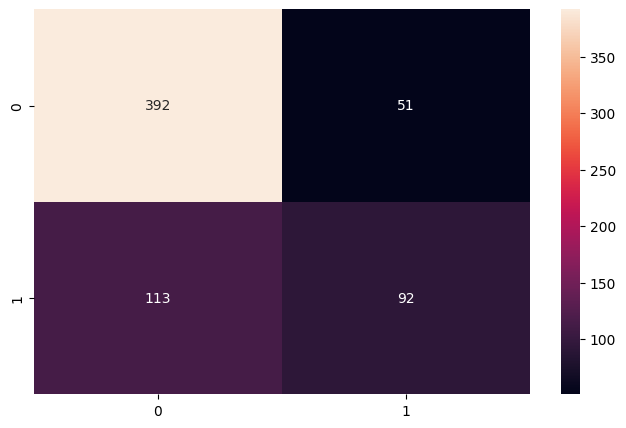

In [31]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='g')
print(classification_report(y_test, pred_labels))

## Continuing Bert Pretraning Usign unlabelled data

In [ ]:
unlabelled_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/Codes /data_unlabelled.csv", index_col=['id'])
print(str(unlabelled_data.shape)+ '\n')
unlabelled_data.head()

(45755, 2)



,text,clean_text
id,,
135828912,باسلام آقامن ازوقتی خودموشناختم مشتری بانک صاد...,باسلام آقامن ازوقتی خودموشناختم مشتری بانک صاد...
135785334,سلام بچه ها میشه با رفیقامون بازی کرد تو این بازی,سلام بچه میشه رفیقامون بازی بازی
135166948,سلام، اینکه برای سفارشهای که توسط فروشنده ارسا...,سلام سفارش فروشنده ارسال میشه هزینه میشه دجی ک...
135727408,سلام لطفا همه چیز رو پولی نکنید مثلا هر پیام د...,سلام پول پیام سکه بردارید اه ممنون
135362055,روز به روز رو به افول هست آخه هر روز هم آپدیت ...,افول آپدیت نمیدن اونم آپدیت بیهوده تازگیا اندر...


In [ ]:
from transformers import BertTokenizer, TFBertForPreTraining

bert_tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model_pretraining = TFBertForPreTraining.from_pretrained("HooshvareLab/bert-fa-base-uncased")


All model checkpoint layers were used when initializing TFBertForPreTraining.

All the layers of TFBertForPreTraining were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


##### Cleaning the unlabelled text

In [ ]:
def cleaning(text):
  # remove spaces
  text = text.strip()
  # removing emojies and unsusual patterns
  wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
  text = emoji.replace_emoji(text, replace='')
  text = wierd_pattern.sub(r'', text)

  return text

In [ ]:
hzm_tokenize = WordTokenizer().tokenize
hzm_lemmaitze = Lemmatizer(joined_verb_parts=False).lemmatize


def my_toknizer(text):
  text = cleaning(text)
  text_tokens = hzm_tokenize(text)
  clean_tokens = [hzm_lemmaitze(token) for token in text_tokens]
  return ' '.join(clean_tokens)


In [ ]:
unlabelled_data.clean_text = unlabelled_data.text.apply(lambda x : my_toknizer(x))

##### preparing  data for Next Sentence Prediction

In [ ]:
bag_of_sentences = [sent for comment in unlabelled_data.clean_text for sent in comment.split('.') if sent !='']
bag_of_sentences_size = len(bag_of_sentences)

In [ ]:
import random

sent_a = []
sent_b = []
label = []

for comment in unlabelled_data.clean_text:
  sentences = [sentence for sentence in comment.split('.') if sentence !='']
  if len(sentences) > 1:
    start = random.randint(0, len(sentences)-2)
    sent_a.append(sentences[start])
    if random.random() > .5:
      sent_b.append(sentences[start+1])
      label.append(0)
    else:
      sent_b.append(bag_of_sentences[random.randint(0, bag_of_sentences_size-1)])
      label.append(1)


In [ ]:
inputs = bert_tokenizer(sent_a, sent_b, return_tensors='tf', max_length=512, truncation=True, padding='max_length')
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
inputs['next_sentence_label'] = tf.transpose(tf.convert_to_tensor([label]))

In [ ]:
inputs['labels'] = inputs.input_ids

##### preparing data for masked language modeling

In [ ]:
rand_mask = tf.random.uniform(inputs.input_ids.shape)
inputs.input_ids.shape

In [ ]:
rand_mask = tf.math.logical_and((rand_mask < 0.15), (inputs.input_ids != 2 ))
rand_mask = tf.math.logical_and(rand_mask, (inputs.input_ids != 4))
rand_mask = tf.math.logical_and(rand_mask, (inputs.input_ids != 0) )

rand_mask

In [ ]:
inputs.input_ids.shape[0]

In [ ]:
np_input_id = inputs.input_ids.numpy()
for i in range(inputs.input_ids.shape[0]):
  selected_mask_indexes = np.array(rand_mask[i]).nonzero()[0]
  for sel_mask_ids in selected_mask_indexes:
    np_input_id[i, sel_mask_ids] = 3

inputs.input_ids = tf.convert_to_tensor(np_input_id)

In [ ]:
inputs.input_ids = tf.convert_to_tensor(np_input_id)

In [ ]:
import tensorflow as tf
pretrain_dataset = tf.data.Dataset.from_tensor_slices((
    dict(inputs),
)).batch(32)

In [ ]:
pretrain_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'next_sentence_label': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'labels': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)},)>

In [ ]:
from tensorflow import keras

bert_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),)

pretrain_bert_history=bert_model.fit(pretrain_dataset.shuffle(100), epochs=50)